<a href="https://colab.research.google.com/github/hab5510/finrl_project/blob/main/with_sentiment_optim_SentVolat/FinRL_with_SentimentAnalysis_optimized_and_sentimentvolatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading, Multiple Stock Trading, with Optimized Sentiment Analysis and Stentiment Volatility.

* **Pytorch Version**



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [ ]:
!pip install numpy==1.26.4 --force-reinstall


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 71.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip install --upgrade pip

!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --extra-index-url https://download.pytorch.org/whl/cpu
!pip install stable-baselines3==2.2.1 sb3-contrib==2.2.1 gymnasium==0.29.1

!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

!pip install transformers==4.41.0 tokenizers==0.19.1 huggingface-hub==0.28.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torchvision-0.21.0+cu124
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.6.0+cu124
    Unins


<a id='1.2'></a>
## 2.2. A list of Python packages
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [ ]:
!pip install pandas_market_calendars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pandas_market_calendars]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

/usr/local/lib/python3.11/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)
/usr/local/lib/python3.11/dist-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

In [ ]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [ ]:
TRAIN_START_DATE = '2020-01-01'
TRAIN_END_DATE = '2023-01-01'
TRADE_START_DATE = '2023-01-01'
TRADE_END_DATE = '2023-12-31'


In [ ]:
top10_tickers = ['AAPL','MSFT','AMZN','GOOGL','META',
                 'NVDA','JPM','TSLA','BA','DIS']

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = top10_tickers).fetch_data()

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (10060, 8)


In [ ]:
df.shape

(10060, 8)

In [ ]:
df.sort_values(['date','tic'],ignore_index=True).head()

Price,date,close,high,low,open,volume,tic,day
0,2020-01-02,72.620819,72.681266,71.373196,71.627069,135480400,AAPL,3
1,2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000,AMZN,3
2,2020-01-02,331.348572,331.378393,325.761816,326.606765,4544400,BA,3
3,2020-01-02,145.769913,145.769913,142.720753,142.907625,9502100,DIS,3
4,2020-01-02,68.026016,68.026016,66.923134,67.018562,27278000,GOOGL,3


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)


Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (1005, 8)
Successfully added vix
Successfully added turbulence index


## Adding Sentiment Analysis Score

The dataset used here is a Financial News Dataset **FNSPID** from https://github.com/Zdong104/FNSPID_Financial_News_Dataset.
It is available at https://huggingface.co/datasets/Zihan1004/FNSPIDfrom where it was directly downloaded as csv and uploaded below.

>
FNSPID (Financial News and Stock Price Integration Dataset), is a comprehensive financial dataset designed to enhance stock market predictions by combining quantitative and qualitative data. It contains 29.7 million stock prices and 15.7 million financial news records for 4,775 S&P500 companies from 1999 to 2023, gathered from four stock market news websites. This dataset stands out for its scale, diversity, and unique incorporation of sentiment information from financial news. Research using FNSPID has shown that its extensive size and quality can significantly improve the accuracy of market predictions. Furthermore, integrating sentiment scores into analyses modestly boosts the performance of transformer-based models. FNSPID also introduces a reproducible method for dataset updates, offering valuable resources for financial research, including complete work, code, documentation, and examples available online. This dataset presents new opportunities for advancing predictive modeling and analysis in the financial research community.




In [ ]:
import pandas as pd

with open("/content/drive/MyDrive/fnspid_news.csv", "r") as f:
    header = f.readline().strip().split(",")
print("CSV columns:", header[:20])    # show first 20 column names


CSV columns: ['Unnamed: 0', 'Date', 'Article_title', 'Stock_symbol', 'Url', 'Publisher', 'Author', 'Article', 'Lsa_summary', 'Luhn_summary', 'Textrank_summary', 'Lexrank_summary']


In [ ]:
import pandas as pd

FILE       = "/content/drive/MyDrive/fnspid_news.csv"
COLS       = ["Date", "Article_title", "Stock_symbol"]
TOP10      = set(['AAPL','MSFT','AMZN','GOOGL','META',
                  'NVDA','JPM','TSLA','BA','DIS'])
DATE_MIN   = "2020-01-01"
DATE_MAX   = "2023-12-31"

chunksize  = 250_000

keep_rows  = []             # list of filtered chunks

for i,chunk in enumerate(pd.read_csv(FILE,
                                     usecols=COLS,
                                     chunksize=chunksize,
                                     dtype={"Stock_symbol":"category"},
                                     engine="c",
                                     low_memory=True)):
    # fast date filter (string compare is OK before to_datetime)
    mask_date   = (chunk["Date"] >= DATE_MIN) & (chunk["Date"] <= DATE_MAX)
    mask_ticker = chunk["Stock_symbol"].isin(TOP10)
    sub         = chunk.loc[mask_date & mask_ticker, COLS]
    if not sub.empty:
        keep_rows.append(sub)
    print(f"processed chunk {i+1}, kept {len(sub)} rows")

# concatenate all kept pieces
df_news = pd.concat(keep_rows, ignore_index=True)

# rename & convert date
df_news = df_news.rename(columns={
    "Date": "date",
    "Article_title": "headline",
    "Stock_symbol": "ticker"
})
df_news["date"] = pd.to_datetime(df_news["date"])

print("Final shape:", df_news.shape)
df_news.head()


processed chunk 1, kept 13647 rows


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
import torch, time
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd

# Load FinBERT
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model     = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
model.eval()

def classify_headlines(texts, batch_size=8, log_every=500):
    results, t0 = [], time.time()
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        encodings = tokenizer(batch, padding=True, truncation=True,
                              max_length=48, return_tensors="pt")
        with torch.no_grad():
            logits = model(**encodings).logits
        preds = torch.argmax(logits, dim=1).tolist()
        results.extend({0:-1, 1:0, 2:1}[p] for p in preds)
        if i % log_every == 0 and i > 0:
            print(f"{i}/{len(texts)} processed ({time.time()-t0:.1f}s)")
    return results


In [ ]:
df_news.head()

In [ ]:
df_news["score"] = classify_headlines(df_news["headline"].tolist())


In [ ]:
df_news.to_csv("scored_news.csv", index=False)       #  saves 56 k rows with sentiment


In [ ]:
df_news = pd.read_csv("scored_news.csv")


In [ ]:

from sklearn.preprocessing import StandardScaler


# 1. Filter for high-news days (at least 2 headlines)
news_counts = df_news.groupby(['date', 'ticker']).size().reset_index(name='headline_count')
df_news = df_news.drop(columns=['headline_count'], errors='ignore')  # avoid merge conflict
df_news = df_news.merge(news_counts, on=['date', 'ticker'])
df_news = df_news[df_news['headline_count'] >= 2]

# 2. Compute daily average sentiment
daily_sent = (df_news[["date", "ticker", "score"]]
              .groupby(["date", "ticker"])
              .mean()
              .rename(columns={"score": "sentiment_score"})
              .reset_index())

# 3. Apply exponential moving average per ticker
daily_sent['date'] = pd.to_datetime(daily_sent['date'])
daily_sent = daily_sent.sort_values(['ticker', 'date'])

daily_sent['sentiment_score'] = daily_sent.groupby('ticker')['sentiment_score'].transform(
    lambda x: x.ewm(span=3, adjust=False).mean()
)

# 4. Add sentiment volatility (3-day rolling std)
daily_sent['sentiment_volatility'] = daily_sent.groupby('ticker')['sentiment_score'].transform(
    lambda x: x.rolling(window=3, min_periods=1).std().fillna(0)
)

# 5. Scale both features
scaler = StandardScaler()
daily_sent[['sentiment_score', 'sentiment_volatility']] = scaler.fit_transform(
    daily_sent[['sentiment_score', 'sentiment_volatility']]
)

# 6. Save or merge
daily_sent.to_csv("daily_sentiment_filtered_scaled.csv", index=False)

# ---- MERGE INTO PROCESSED DATA ----
daily_sent = pd.read_csv("daily_sentiment_filtered_scaled.csv")
daily_sent["date"] = pd.to_datetime(daily_sent["date"]).dt.strftime("%Y-%m-%d")
processed["date"] = pd.to_datetime(processed["date"]).dt.strftime("%Y-%m-%d")

processed = processed.merge(
    daily_sent,
    left_on=["date", "tic"],
    right_on=["date", "ticker"],
    how="left"
)

# Fill missing sentiment with 0
processed['sentiment_score'] = processed['sentiment_score'].fillna(0)
processed['sentiment_volatility'] = processed['sentiment_volatility'].fillna(0)

if 'ticker' in processed.columns:
    processed = processed.drop(columns=['ticker'])

print("Sentiment integrated with EMA, volatility, and scaling.")


Sentiment integrated with EMA, volatility, and scaling.


In [ ]:
# build processed_full so the RL environment sees every (date, ticker)
list_ticker = processed["tic"].unique().tolist()
list_date   = list(pd.date_range(processed['date'].min(),
                                 processed['date'].max()).astype(str))
combination = list(itertools.product(list_date, list_ticker))

processed_full = (
    pd.DataFrame(combination, columns=["date", "tic"])
      .merge(processed, on=["date", "tic"], how="left")
)
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date', 'tic'])
processed_full = processed_full.fillna(0)


In [ ]:
processed_full.to_csv("processed_full_filtered_scaled.csv", index=False)

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [ ]:
INDICATORS = [
    'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30',
    'close_30_sma', 'close_60_sma', 'sentiment_score', 'sentiment_volatility','vix', 'turbulence'
]

In [ ]:
# Keep only the valid columns

VALID_COLUMNS = ['date', 'tic', 'open', 'high', 'low', 'close', 'volume','day'] + INDICATORS
processed_full = pd.read_csv("processed_full_filtered_scaled.csv")
processed_full = processed_full[VALID_COLUMNS]
processed_full.dropna(inplace=True)

In [ ]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(20)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,sentiment_score,sentiment_volatility,vix,turbulence
0,2020-01-02,AAPL,71.627069,72.681266,71.373196,72.620819,135480400.0,3.0,0.000000,73.266248,71.269396,0.0,-66.666667,100.0,72.620819,72.620819,0.000000,0.000000,12.47,0.0
1,2020-01-02,AMZN,93.750000,94.900497,93.207497,94.900497,80580000.0,3.0,0.000000,73.266248,71.269396,0.0,-66.666667,100.0,94.900497,94.900497,0.000000,0.000000,12.47,0.0
2,2020-01-02,BA,326.606765,331.378393,325.761816,331.348572,4544400.0,3.0,0.000000,73.266248,71.269396,0.0,-66.666667,100.0,331.348572,331.348572,-2.783217,-1.578261,12.47,0.0
3,2020-01-02,DIS,142.907625,145.769913,142.720753,145.769913,9502100.0,3.0,0.000000,73.266248,71.269396,0.0,-66.666667,100.0,145.769913,145.769913,0.148809,2.230375,12.47,0.0
4,2020-01-02,GOOGL,67.018562,68.026016,66.923134,68.026016,27278000.0,3.0,0.000000,73.266248,71.269396,0.0,-66.666667,100.0,68.026016,68.026016,-1.154314,-1.578261,12.47,0.0
5,2020-01-02,JPM,119.621105,120.742109,119.167574,120.733543,10803700.0,3.0,0.000000,73.266248,71.269396,0.0,-66.666667,100.0,120.733543,120.733543,0.881815,-1.578261,12.47,0.0
6,2020-01-02,META,205.621910,208.645316,205.144533,208.635376,12077100.0,3.0,0.000000,73.266248,71.269396,0.0,-66.666667,100.0,208.635376,208.635376,0.000000,0.000000,12.47,0.0
7,2020-01-02,MSFT,151.289108,153.147108,150.860341,153.042297,22622100.0,3.0,0.000000,73.266248,71.269396,0.0,-66.666667,100.0,153.042297,153.042297,0.000000,0.000000,12.47,0.0
8,2020-01-02,NVDA,5.942873,5.971747,5.892344,5.971747,237536000.0,3.0,0.000000,73.266248,71.269396,0.0,-66.666667,100.0,5.971747,5.971747,0.000000,0.000000,12.47,0.0
9,2020-01-02,TSLA,28.299999,28.713333,28.114000,28.684000,142981500.0,3.0,0.000000,73.266248,71.269396,0.0,-66.666667,100.0,28.684000,28.684000,-0.339862,-1.578261,12.47,0.0


In [ ]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

7560
2490


In [ ]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,sentiment_score,sentiment_volatility,vix,turbulence
755,2022-12-30,JPM,124.543634,125.969030,124.196668,125.753349,9292500.0,4.0,0.423459,126.849709,120.917194,57.143995,20.442073,11.345561,124.882476,119.589301,0.000000,0.000000,21.67,0.766243
755,2022-12-30,META,117.515312,119.762976,117.097598,119.683411,19583800.0,4.0,0.952231,122.984847,111.411241,49.419036,78.427365,9.186683,115.435049,115.697442,0.000000,0.000000,21.67,0.766243
755,2022-12-30,MSFT,233.466220,235.181370,231.947085,235.044159,21938500.0,4.0,-1.366761,253.270824,227.343632,48.258151,-86.505273,5.313322,240.472862,234.587167,0.526060,0.162056,21.67,0.766243
755,2022-12-30,NVDA,14.321271,14.616009,14.220361,14.601023,310490000.0,4.0,-0.309793,18.503087,13.800797,47.045450,-141.558804,13.239365,16.120590,14.735053,1.212132,0.499243,21.67,0.766243
755,2022-12-30,TSLA,119.949997,124.480003,119.750000,123.180000,157777300.0,4.0,-19.258998,202.513339,99.254662,32.790586,-121.998583,47.953532,161.267667,186.598834,0.698712,-0.662617,21.67,0.766243


In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,sentiment_score,sentiment_volatility,vix,turbulence
0,2023-01-03,AAPL,128.614001,129.226068,122.582134,123.470627,112117500.0,1.0,-4.648597,147.860256,121.091849,39.011479,-130.963458,35.956281,138.293932,140.567290,-0.0803,-1.501889,22.9,29.954478
0,2023-01-03,AMZN,85.459999,86.959999,84.209999,85.820000,76706000.0,1.0,-3.075118,93.357149,80.929850,41.195599,-71.360174,10.198927,89.424999,97.181000,0.0000,0.000000,22.9,29.954478
0,2023-01-03,BA,192.949997,197.179993,192.399994,195.389999,8624600.0,1.0,5.326285,196.702727,176.154272,62.905353,141.206999,44.456630,182.859667,166.269167,0.0000,0.000000,22.9,29.954478
0,2023-01-03,DIS,87.520962,88.494726,86.389817,87.511124,14997100.0,1.0,-2.395933,95.452684,81.433497,44.489009,-57.420742,3.756627,90.752426,93.693725,1.0905,1.283681,22.9,29.954478
0,2023-01-03,GOOGL,89.055883,90.507186,87.992263,88.588692,28131200.0,1.0,-2.129975,98.089503,83.452724,43.976938,-67.730997,2.932482,92.974731,93.988817,0.0000,0.000000,22.9,29.954478


In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 10, State Space: 141


In [ ]:

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
import numpy as np

EXPECTED_STATE_DIM = state_space

def force_fixed_state(obs):
    obs = np.asarray(obs, dtype=np.float32).flatten()
    if obs.shape[0] != EXPECTED_STATE_DIM:
        print(f"Auto-fixing bad obs shape {obs.shape[0]} → {EXPECTED_STATE_DIM}")
        if obs.shape[0] < EXPECTED_STATE_DIM:
            # Pad with zeros
            obs = np.pad(obs, (0, EXPECTED_STATE_DIM - obs.shape[0]), mode='constant')
        else:
            # Truncate
            obs = obs[:EXPECTED_STATE_DIM]
    return obs.reshape(1, -1)


class PatchedStockTradingEnv(StockTradingEnv):
    def reset(self, *, seed=None, options=None):
        obs, info = super().reset(seed=seed, options=options)
        obs = force_fixed_state(obs)
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)
        obs = force_fixed_state(obs)
        return obs, reward, terminated, truncated, info








In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

from stable_baselines3.common.vec_env import DummyVecEnv

env_train = DummyVecEnv([lambda: PatchedStockTradingEnv(df=train, **env_kwargs)])






## Environment for Training



In [ ]:


obs = env_train.reset()
print("obs shape:", obs.shape, "dtype:", obs.dtype)

action = np.zeros(stock_dimension)
obs, reward, done, info = env_train.step(action)
print("step shape:", obs.shape, "dtype:", obs.dtype)


obs shape: (1, 141) dtype: float32
step shape: (1, 141) dtype: float32


/usr/local/lib/python3.11/dist-packages/finrl/meta/env_stock_trading/env_stocktrading.py:328: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]


In [ ]:
obs = env_train.reset()
print("Training reset shape:", obs.shape, obs.dtype)

obs, reward, done, info = env_train.step(np.zeros(stock_dimension))
print("Training step shape:", obs.shape, obs.dtype)



Training reset shape: (1, 141) float32
Training step shape: (1, 141) float32


<a id='5'></a>
# Part 6: Train  DRL Agents
* The DRL algorithms are from **Stable Baselines 3**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3.

### Agent Training: 3 algorithms (A2C,PPO, TD3)


### Agent 1: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")


# set up logger
tmp_path = RESULTS_DIR + '/a2c'
new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [ ]:
print(repr(env_train.reset()))

array([[ 1.0000000e+06,  7.2620819e+01,  9.4900497e+01,  3.3134857e+02,
         1.4576991e+02,  6.8026016e+01,  1.2073354e+02,  2.0863538e+02,
         1.5304230e+02,  5.9717474e+00,  2.8684000e+01,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  7.3266251e+01,
         7.3266251e+01,  7.3266251e+01,  7.3266251e+01,  7.3266251e+01,
         7.3266251e+01,  7.3266251e+01,  7.3266251e+01,  7.3266251e+01,
         7.3266251e+01,  7.1269394e+01,  7.1269394e+01,  7.1269394e+01,
         7.1269394e+01,  7.1269394e+01,  7.1269394e+01,  7.1269394e+01,
         7.1269394e+01,  7.1269394e+01,  7.1269394e+01,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.00000

In [ ]:
trained_a2c  = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000)

-------------------------------------
| time/                 |           |
|    fps                | 230       |
|    iterations         | 100       |
|    time_elapsed       | 2         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -14.3     |
|    explained_variance | 0.021     |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -48.9     |
|    reward             | 1.2043394 |
|    reward_max         | 5.158179  |
|    reward_mean        | 2.4673498 |
|    reward_min         | -3.481056 |
|    std                | 1.01      |
|    value_loss         | 17.4      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 198        |
|    iterations         | 200        |
|    time_elapsed       | 5          |
|    total_timesteps    | 1000       |
| train/                |            |
|    

### Agent 2: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

  # set up logger
tmp_path = RESULTS_DIR + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [ ]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=50000)

--------------------------------------
| time/              |               |
|    fps             | 314           |
|    iterations      | 1             |
|    time_elapsed    | 6             |
|    total_timesteps | 2048          |
| train/             |               |
|    reward          | 0.6609027     |
|    reward_max      | 6.970998      |
|    reward_mean     | -0.0023426574 |
|    reward_min      | -14.979908    |
--------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2           |
|    time_elapsed         | 14          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008378252 |
|    clip_fraction        | 0.0925      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.2       |
|    explained_variance   | 0.0207      |
|    learning_rate        | 

### Agent 3: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

  # set up logger
tmp_path = RESULTS_DIR + '/td3'
new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [ ]:
trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000)

Logging Error: 'rollout_buffer'
day: 755, episode: 140
begin_total_asset: 1000000.00
end_total_asset: 836579.87
total_reward: -163420.13
total_cost: 999.00
total_trades: 3020
Sharpe: 0.028
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
------------------------------------
| time/              |             |
|    episodes        | 4           |
|    fps             | 45          |
|    time_elapsed    | 66          |
|    total_timesteps | 3024        |
| train/             |             |
|    actor_loss      | -84         |
|    critic_loss     | 6.79e+03    |
|    learning_rate   | 0.001       |
|    n_updates       | 2268        |
|    reward          | 0.016671898 |
|    reward_max      | None        |
|    reward_mean     | None        |
|    reward_min      | None        |
------------------------------------
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
---------------------------

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [ ]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [ ]:
insample_risk_indicator.vix.describe()

,vix
count,756.000000
mean,24.848664
std,8.759434
min,12.100000
25%,19.367501
50%,23.134999
75%,27.990000
max,82.690002


In [ ]:
insample_risk_indicator.vix.quantile(0.996)

75.40060119628913

In [ ]:
insample_risk_indicator.turbulence.describe()

,turbulence
count,756.000000
mean,7.637636
std,16.377615
min,0.000000
25%,0.000000
50%,4.191970
75%,9.347969
max,293.467621


In [ ]:
insample_risk_indicator.turbulence.quantile(0.996)

102.95673018861805

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,sentiment_score,sentiment_volatility,vix,turbulence
0,2023-01-03,AAPL,128.614001,129.226068,122.582134,123.470627,112117500.0,1.0,-4.648597,147.860256,121.091849,39.011479,-130.963458,35.956281,138.293932,140.567290,-0.0803,-1.501889,22.9,29.954478
0,2023-01-03,AMZN,85.459999,86.959999,84.209999,85.820000,76706000.0,1.0,-3.075118,93.357149,80.929850,41.195599,-71.360174,10.198927,89.424999,97.181000,0.0000,0.000000,22.9,29.954478
0,2023-01-03,BA,192.949997,197.179993,192.399994,195.389999,8624600.0,1.0,5.326285,196.702727,176.154272,62.905353,141.206999,44.456630,182.859667,166.269167,0.0000,0.000000,22.9,29.954478
0,2023-01-03,DIS,87.520962,88.494726,86.389817,87.511124,14997100.0,1.0,-2.395933,95.452684,81.433497,44.489009,-57.420742,3.756627,90.752426,93.693725,1.0905,1.283681,22.9,29.954478
0,2023-01-03,GOOGL,89.055883,90.507186,87.992263,88.588692,28131200.0,1.0,-2.129975,98.089503,83.452724,43.976938,-67.730997,2.932482,92.974731,93.988817,0.0000,0.000000,22.9,29.954478


In [ ]:
trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value_a2c.shape

(249, 2)

<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])

result = pd.merge(df_result_a2c, df_result_ppo, left_index=True, right_index=True, suffixes=('_a2c', '_ppo'))
result = pd.merge(result, df_result_td3, left_index=True, right_index=True,suffixes=('', '_td3'))


df_account_value_a2c.to_csv("df_account_value_a2c.csv")
df_account_value_ppo.to_csv("df_account_value_ppo.csv")
df_account_value_td3.to_csv("df_account_value_td3.csv")



#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")
result = pd.merge(result, df_dji, left_index=True, right_index=True, suffixes=('', '_dji'))
result.columns = ['a2c','ppo', 'td3','dji']
print("result: ", result)
result.to_csv("result.csv")

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (250, 8)
Annual return          0.138579
Cumulative returns     0.137407
Annual volatility      0.114284
Sharpe ratio           1.197347
Calmar ratio           1.536735
Stability              0.375744
Max drawdown          -0.090178
Omega ratio            1.213376
Sortino ratio          1.790631
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.100346
Daily value at risk   -0.013855
dtype: float64
result:                       a2c           ppo           td3           dji
date                                                              
2023-01-03  1.000000e+06  1.000000e+06  1.000000e+06  1.000000e+06
2023-01-04  9.993159e+05  1.000023e+06  1.000084e+06  1.004026e+06
2023-01-05  9.977983e+05  1.000021e+06  9.988613e+05  9.937744e+05
2023-01-06  9.995931e+05  1.000068e+06  1.002750e+06  1.014915e+06
2023-01-09  1.000831e+06  1.000094e+06  1.002424e+06  1.011506e+06
...              

<Figure size 1500x500 with 0 Axes>

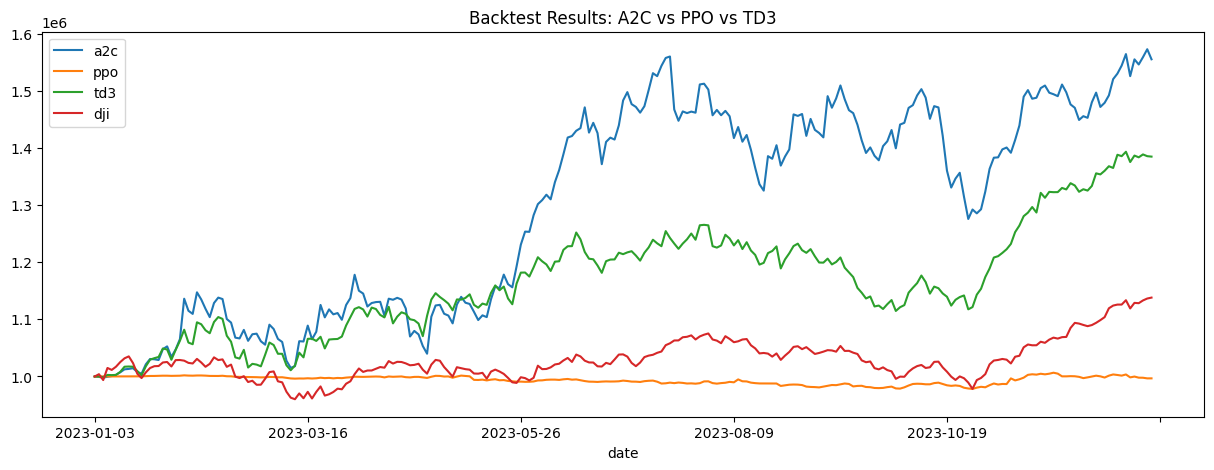

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot(title="Backtest Results: A2C vs PPO vs TD3");

In [ ]:
import numpy as np
import pandas as pd

def backtest_stats(account_value, value_col_name='account_value'):
    daily_return = account_value[value_col_name].pct_change(1).dropna()

    cum_return = account_value[value_col_name].iloc[-1] / account_value[value_col_name].iloc[0] - 1
    annual_volatility = np.std(daily_return) * np.sqrt(252)
    sharpe_ratio = np.mean(daily_return) / np.std(daily_return) * np.sqrt(252)

    cumulative = (1 + daily_return).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_drawdown = drawdown.min()

    stats = {
        'Cumulative Return': cum_return,
        'Annual Volatility': annual_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

    return pd.Series(stats)


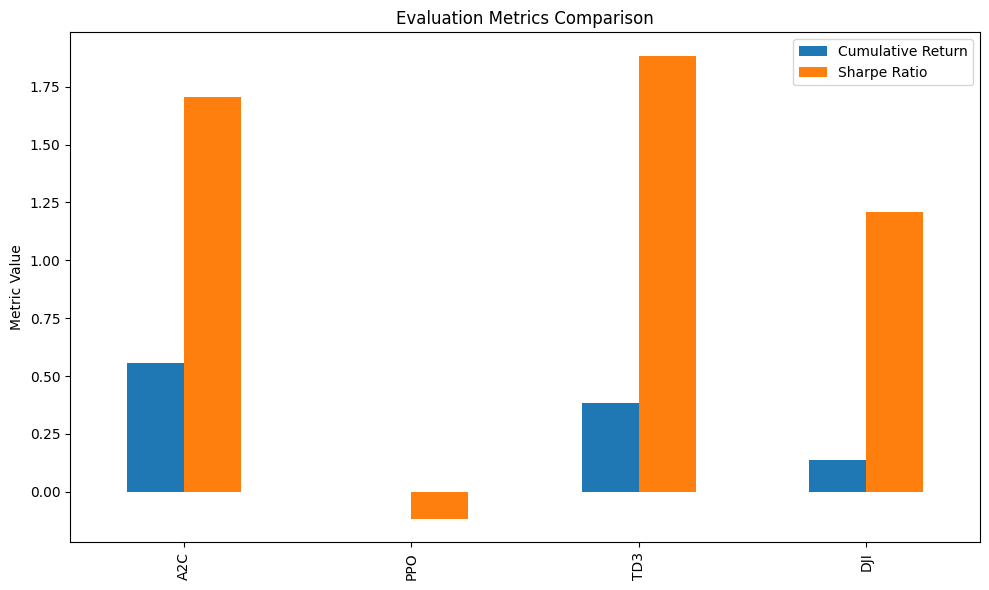

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

stats_a2c = backtest_stats(df_account_value_a2c)
stats_ppo = backtest_stats(df_account_value_ppo)
stats_td3 = backtest_stats(df_account_value_td3)
stats_dji = backtest_stats(df_dji)  #  df_dji with  'account_value' coumn added


metrics_df = pd.DataFrame({
    "A2C": stats_a2c,
    "PPO": stats_ppo,
    "TD3": stats_td3,
    "DJI": stats_dji
})

top_metrics = ["Cumulative Return", "Sharpe Ratio"]
metrics_df_filtered = metrics_df.loc[top_metrics]

# Transpose to have models on x-axis
plot_df = metrics_df_filtered.T

# Plot and store axis object
ax = plot_df.plot(kind='bar', figsize=(10, 6))
plt.title("Evaluation Metrics Comparison")
plt.ylabel("Metric Value")

plt.tight_layout()
plt.show()


In [ ]:
from IPython.display import display

# Round the values for better presentation
display(metrics_df_filtered.T.round(3))

plt.savefig("evaluation_metrics_comparison.png", dpi=300)
metrics_df_filtered.T.to_csv("evaluation_metrics_table.csv")



,Cumulative Return,Sharpe Ratio
A2C,0.555,1.705
PPO,-0.003,-0.118
TD3,0.385,1.885
DJI,0.138,1.207


<Figure size 1500x500 with 0 Axes>